In [1]:
using NBInclude
@nbinclude("functions.ipynb")

All function imported


In [3]:
#setup
x_dim = 784
k = 20
epoch_to_load = 16 # Load the model 
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
trials = 20
opt = Flux.Optimise.ADAM(.1);

_, _, decoder = load_model("trained_GNN/MNIST", 20)
A = Flux.params(decoder)[3]
z = randn(k) # ground code vector
F = dct(diagm(ones(x_dim)),2);

B = randn(784,500)/sqrt(784)
β_list, α_list = get_β_α(F, A, B, 21);
m_list = 20:20:440

Loading model...Done

20:20:440

In [41]:
phase_matrix_recovery = zeros(trials, length(m_list), length(β_list))
phase_matrix_recon = zeros(trials, length(m_list), length(β_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    recovery_error_matrix = zeros(trials)
    recon_error_matrix = zeros(trials)
    for β in β_list
        recovery_error_list = []
        recon_error_list = []
        G = Chain(
            Dense(20, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[1]),
            Dense(500, 500, relu, bias = false; init =(out,in) -> Flux.params(decoder)[2]),
            Dense(500, 784, identity, bias = false; init =(out,in) -> β * A + (1 - β) *B),
        )      #setup the generative network 

        Threads.@threads for trials in 1:trials
            F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
            F_sub = F_sub * sqrt(x_dim)/sqrt(m) #normalization          
            y = F_sub * G(z) # measurement vector using subsampled DCT matrix

            z_est = randn(k) #initialization for algorithm
            z_est = estimated_code(opt, G, y, F_sub, z_est; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem

            push!(recovery_error_list, relative_error(z, z_est))    
            push!(recon_error_list, relative_error(G(z), G(z_est)))
        end

        recovery_error_matrix =  hcat(recovery_error_matrix, recovery_error_list)
        recon_error_matrix = hcat(recon_error_matrix, recon_error_list)
    end
    phase_matrix_recovery[:, i, :] = recovery_error_matrix[:, 2:end]
    phase_matrix_recon[:, i, :] = recon_error_matrix[:, 2:end]
    println("Done with m = $m")
println("")


Done with m = 20



In [5]:
# save("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recovery", phase_matrix_recovery, "phase_matrix_recon", phase_matrix_recon, "α_list", α_list, "m_list", m_list, "trials", trials)
phase_matrix_recovery =load("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recovery")
phase_matrix_recon =load("saved_data/Phase_plot_full_MNIST.jld", "phase_matrix_recon")
α_list =load("saved_data/Phase_plot_full_MNIST.jld", "α_list")
m_list =load("saved_data/Phase_plot_full_MNIST.jld", "m_list")
trials =load("saved_data/Phase_plot_full_MNIST.jld", "trials")

20

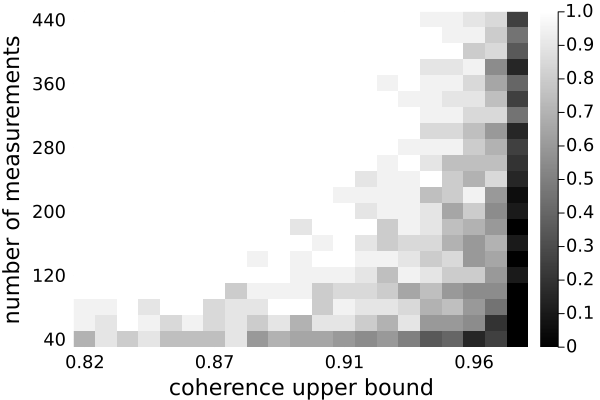

In [6]:
M = zeros(size(phase_matrix_recon[1,:,:]))
for trial in 1:trials
    M += (phase_matrix_recovery[trial,:,:] .< 1e-5)
end

plot(heatmap(M/trials, c =:gist_gray),bg =:white,framestyle = :box, showaxis =:false,  xlabel = "coherence upper bound", ylabel = "number of measurements",  xlabelfontsize = 15, ylabelfontsize = 15, xtickfontsize = 12, ytickfontsize = 12  )
xticks = 1:6:length(α_list)
xticks!(xticks, ["$(round.(α_list, digits = 2)[i])" for i in 1:6:length(α_list)])
yticks = 1:4:length(m_list)
yticks!(yticks, ["$(m_list[i])" for i in 1:4:length(m_list)])

